# Обучение модели LSTM

In [0]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version  2.x

In [0]:
os.chdir('/content/drive/Shared drives/Кредитные риски')
!pip install category_encoders catboost

     |████████████████████████████████| 102kB 2.1MB/s 
     |████████████████████████████████| 64.4MB 48kB/s 


In [0]:
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/metrics_library')))
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/PythonBackend')))

In [0]:
import pandas as pd
import numpy as np
import os
import io
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import category_encoders
import matplotlib.pyplot as plt

In [0]:
from calc_model.lr_model import Winsorizator
from feature_generation import add_features
import profits

In [0]:
DIR_IN = 'Датасеты/revision_006/'

## Считывание данных

In [0]:
df_train = pd.read_pickle(f'{DIR_IN}companies_ready_train.pkl')
y_train = df_train['target']
x_train = df_train.drop(columns=['target'])

df_test = pd.read_pickle(f'{DIR_IN}companies_ready_test.pkl')
y_test = df_test['target']
x_test = df_test.drop(columns=['target'])

df_prod = pd.read_pickle(f'{DIR_IN}companies_ready_prod.pkl')
y_prod = df_prod['target']
x_prod = df_prod.drop(columns=['target'])

## Предобработка данных

### Добавление новых признаков

In [0]:
add_features(x_train)
add_features(x_test)
add_features(x_prod)

In [0]:
features_all = ['region', 'year_-1_1100', 'year_-1_1150', 'year_-1_1200',
       'year_-1_1210', 'year_-1_1300', 'year_-1_1310', 'year_-1_1500',
       'year_-1_1520', 'year_-1_2110', 'year_-1_2120',
       'year_-1_AssetTurnover',
       'year_-1_CoverageDebtWithAccumulatedProfit',
       'year_-1_CreditLeverage', 'year_-1_CurrentLiquidity',
       'year_-1_DebtBurden', 'year_-1_LevelOfOperatingAssets',
       'year_-1_LiabilityCoverageOperatingProfit',
       'year_-1_NetProfitMargin',
       'year_-1_OperatingProfitFinancialDebtRatio',
       'year_-1_QuickLiquidity', 'year_-1_ReturnAssetsNetProfit',
       'year_-1_okved', 'year_-1_okved1', 'year_-1_okved2',
       'year_-2_1150', 'year_-2_1200', 'year_-2_1230', 'year_-2_1310',
       'year_-2_1500', 'year_-2_1520', 'year_-2_1600', 'year_-2_2100',
       'year_-2_2110', 'year_-2_2120', 'year_-2_2300', 'year_-2_2400',
       'year_0_1100', 'year_0_1150', 'year_0_1200', 'year_0_1210',
       'year_0_1230', 'year_0_1250', 'year_0_1300', 'year_0_1310',
       'year_0_1500', 'year_0_1520', 'year_0_2300', 'year_0_2400',
       'year_0_AssetTurnover', 'year_0_CoverageDebtWithAccumulatedProfit',
       'year_0_CreditLeverage', 'year_0_DebtBurden',
       'year_0_FinancialCycle', 'year_0_InstantLiquidity',
       'year_0_LevelOfOperatingAssets',
       'year_0_LiabilityCoverageOperatingProfit',
       'year_0_NetProfitMargin',
       'year_0_OperatingProfitFinancialDebtRatio',
       'year_0_ReturnAssetsNetProfit', 'year_0_financialDebt',
       'year_0_okved', 'year_0_okved1', 'year_0_okved2',
       'year_0_turnoverCreditDebt', 'year_0_turnoverDebtorDebt',
       'year_0_turnoverReserves']
features_all = np.array(features_all)
del features_all

In [0]:
# x_train = x_train[features_all]
# x_test = x_test[features_all]
# x_prod = x_prod[features_all]

### Стандартизация, винзоризация и выброс категориальных признаков

In [0]:
features_all = x_train.columns.values

In [0]:
features_cat = ['region', ]
for year in ['-1', '0']:
    for col in ['okved', 'okved2', 'okved1', ]:
        features_cat.append(f'year_{year}_{col}')    
assert set(features_cat) & set(features_all) == set(features_cat)
features_float = np.array(sorted(list(set(features_all) - set(features_cat))))

In [0]:
catboost_encoder = category_encoders.CatBoostEncoder(cols=features_cat, random_state=42)
__x_train_cat = catboost_encoder.fit_transform(x_train[features_cat],  y_train)
__x_test_cat = catboost_encoder.transform(x_test[features_cat])

In [0]:
catboost_encoder_prod = category_encoders.CatBoostEncoder(cols=features_cat, random_state=42)
__x_prod_cat = catboost_encoder_prod.fit_transform(x_prod[features_cat],  y_prod)

In [0]:
sc = StandardScaler()
winz = Winsorizator(0.3, 0.7)

In [0]:
__x_train_float = x_train[features_float].copy()
winz.fit_transform(__x_train_float)
__x_train = pd.concat([__x_train_float, __x_train_cat], axis=1)
__x_train = pd.DataFrame(sc.fit_transform(__x_train), columns=__x_train.columns, index=__x_train.index)

__x_test_float = x_test[features_float].copy()
winz.transform(__x_test_float)
__x_test = pd.concat([__x_test_float, __x_test_cat], axis=1)
__x_test = pd.DataFrame(sc.transform(__x_test), columns=__x_test.columns, index=__x_test.index)

In [0]:
sc_prod = StandardScaler()
winz_prod = Winsorizator(0.3, 0.7)

In [0]:
__x_prod_float = x_prod[features_float].copy()
winz_prod.fit_transform(__x_prod_float)
__x_prod = pd.concat([__x_prod_float, __x_prod_cat], axis=1)
__x_prod = pd.DataFrame(sc_prod.fit_transform(__x_prod), columns=__x_prod.columns, index=__x_prod.index)

## Обучение

In [0]:
def plt_to_bytes():
    b = io.BytesIO()
    plt.savefig(b, format="png")
    b.seek(0)
    return b.read()

In [0]:
def measure_quality(y_true: np.array, y_predict: np.array, name=None):
    print("ROC AUC: ", roc_auc_score(y_true, y_predict))
    plts = {}
    profits.plt_profit(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit'] = plt_to_bytes()
    profits.plt_profit_recall(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit_recall'] = plt_to_bytes()
    profits.plt_popularity(y_predict, title=name) 
    plts['plt_popularity'] = plt_to_bytes()
    return plts

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.optimizers import Adamax, Adam

In [0]:
lag_cols = []
for year in [-2, -1, 0]:
    cols = []
    for col in [1150, 1200, 1310, 1500, 1520, 1230, 1600, 2110, 2400]:
        cols.append(f'year_{year}_{col}')
    lag_cols.append(cols)

lag_cols2 = []
for year in [-1, 0]:
    cols = []
    for col in ['AssetTurnover', 'CoverageDebtWithAccumulatedProfit', 'CreditLeverage',
                'DebtBurden', 'LevelOfOperatingAssets', 'LiabilityCoverageOperatingProfit',
                'NetProfitMargin', 'OperatingProfitFinancialDebtRatio', 'ReturnAssetsNetProfit',
                'CurrentLiquidity', 'FinancialCycle', 'FinancialDebtRevenueRatio', 'FinancialIndependence', 
                'InstantLiquidity', 'OperatingMargin', 'QuickLiquidity',  'ReturnAssetsOperatingProfit', 
                'financialDebt', 'turnoverCreditDebt', 'turnoverDebtorDebt', 'turnoverReserves',
                'okved', 'okved1', 'okved2', '1100', '1210', '1300', '1400', '1250', '2200', ]:
        cols.append(f'year_{year}_{col}')
    lag_cols2.append(cols)
ordinal_cols = np.array(sorted(list(set(__x_train.columns) - set(lag_cols[0] + lag_cols[1] + lag_cols[2]) - set(lag_cols2[0] + lag_cols2[1]))))

In [0]:
ordinal_cols

array(['region', 'year_-1_2120', 'year_-2_1210', 'year_-2_2100',
       'year_-2_2120', 'year_-2_2300', 'year_0_2300'], dtype='<U12')

In [0]:
lag_cols

[['year_-2_1150',
  'year_-2_1200',
  'year_-2_1310',
  'year_-2_1500',
  'year_-2_1520',
  'year_-2_1230',
  'year_-2_1600',
  'year_-2_2110',
  'year_-2_2400'],
 ['year_-1_1150',
  'year_-1_1200',
  'year_-1_1310',
  'year_-1_1500',
  'year_-1_1520',
  'year_-1_1230',
  'year_-1_1600',
  'year_-1_2110',
  'year_-1_2400'],
 ['year_0_1150',
  'year_0_1200',
  'year_0_1310',
  'year_0_1500',
  'year_0_1520',
  'year_0_1230',
  'year_0_1600',
  'year_0_2110',
  'year_0_2400']]

In [0]:
data_train_1 = np.stack([__x_train[cols].values for cols in lag_cols])
data_train_1 = np.moveaxis(data_train_1, 1, 0)
__x_train.shape, data_train_1.shape

data_train_2 = np.stack([__x_train[cols].values for cols in lag_cols2])
data_train_2 = np.moveaxis(data_train_2, 1, 0)
__x_train.shape, data_train_2.shape

data_train_3 = __x_train[ordinal_cols]

In [0]:
data_test_1 = np.stack([__x_test[cols].values for cols in lag_cols])
data_test_1 = np.moveaxis(data_test_1, 1, 0)
__x_test.shape, data_test_1.shape

data_test_2 = np.stack([__x_test[cols].values for cols in lag_cols2])
data_test_2 = np.moveaxis(data_test_2, 1, 0)
__x_test.shape, data_test_2.shape

data_test_3 = __x_test[ordinal_cols]

In [0]:
def make_lstm(inp, size):
    x = Bidirectional(LSTM(size, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(inp)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    return x

In [0]:
inp1 = Input(shape=data_train_1.shape[1:], name='3_years')
inp2 = Input(shape=data_train_2.shape[1:], name='2_years')
inp3 = Input(shape=data_train_3.shape[1:], name='other')
x1 = make_lstm(inp1, 9)
x2 = make_lstm(inp2, 30)
x3 = Dense(20, activation="relu")(inp3)

x = concatenate([x1, x2, x3])
x = Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[inp1, inp2, inp3], outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(clipvalue=2, clipnorm=2), metrics=['AUC'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
3_years (InputLayer)            [(None, 3, 9)]       0                                            
__________________________________________________________________________________________________
2_years (InputLayer)            [(None, 2, 30)]      0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 3, 18)        1368        3_years[0][0]                    
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 2, 60)        14640       2_years[0][0]                    
____________________________________________________________________________________________

In [0]:
model.fit([data_train_1, data_train_2, data_train_3], y_train, batch_size=256, epochs=5, validation_data=([data_test_1, data_test_2, data_test_3], y_test))

Epoch 1/5
4022/4022 [==============================] - 262s 65ms/step - loss: 0.3685 - auc: 0.8720 - val_loss: 0.4249 - val_auc: 0.6960
Epoch 2/5
4022/4022 [==============================] - 261s 65ms/step - loss: 0.3550 - auc: 0.8798 - val_loss: 0.4238 - val_auc: 0.6981
Epoch 3/5
4022/4022 [==============================] - 263s 65ms/step - loss: 0.3518 - auc: 0.8816 - val_loss: 0.4258 - val_auc: 0.7002
Epoch 4/5
4022/4022 [==============================] - 263s 65ms/step - loss: 0.3498 - auc: 0.8831 - val_loss: 0.4243 - val_auc: 0.7012
Epoch 5/5
 283/4022 [=>............................] - ETA: 3:39 - loss: 0.3508 - auc: 0.8823

KeyboardInterrupt: ignored

In [0]:
def make_lstm(inp, size):
    x = Bidirectional(LSTM(size, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(inp)
    return x
    
inp1 = Input(shape=data_train_1.shape[1:], name='3_years')
inp2 = Input(shape=data_train_2.shape[1:], name='2_years')
inp3 = Input(shape=data_train_3.shape[1:], name='other')
x1 = make_lstm(inp1, 9)
x2 = make_lstm(inp2, 30)
x3 = Dense(20, activation="relu")(inp3)

x = concatenate([x1, x2, x3])
x = Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[inp1, inp2, inp3], outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(clipvalue=2, clipnorm=2), metrics=['AUC'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
3_years (InputLayer)            [(None, 3, 9)]       0                                            
__________________________________________________________________________________________________
2_years (InputLayer)            [(None, 2, 30)]      0                                            
__________________________________________________________________________________________________
other (InputLayer)              [(None, 7)]          0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 18)           1368        3_years[0][0]                    
____________________________________________________________________________________________

In [0]:
model.fit([data_train_1, data_train_2, data_train_3], y_train, batch_size=256, epochs=3, validation_data=([data_test_1, data_test_2, data_test_3], y_test))

Epoch 1/3
4022/4022 [==============================] - 260s 65ms/step - loss: 0.3638 - auc: 0.8746 - val_loss: 0.4264 - val_auc: 0.6959
Epoch 2/3
4022/4022 [==============================] - 259s 64ms/step - loss: 0.3521 - auc: 0.8815 - val_loss: 0.4232 - val_auc: 0.6998
Epoch 3/3
4022/4022 [==============================] - 260s 65ms/step - loss: 0.3493 - auc: 0.8833 - val_loss: 0.4225 - val_auc: 0.7010


In [0]:
proba = model.predict([data_test_1, data_test_2, data_test_3], batch_size=1024, verbose=1)[:, 0]

756/756 [==============================] - 5s 7ms/step


ROC AUC:  0.7010051879639878


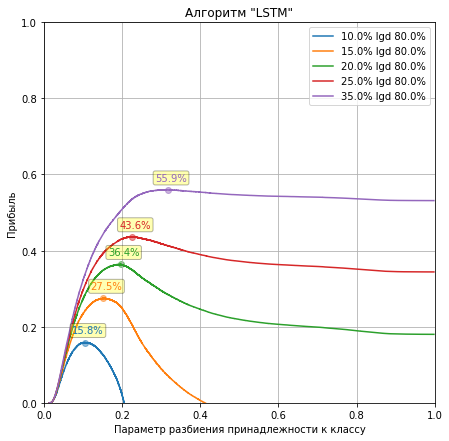

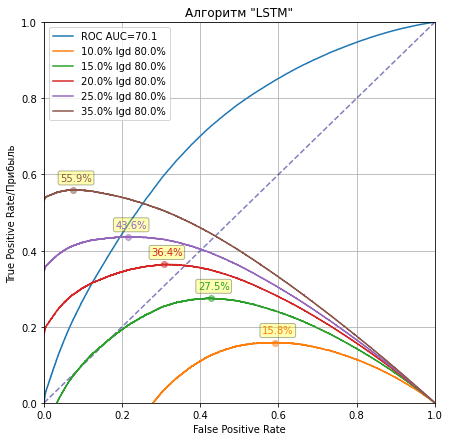

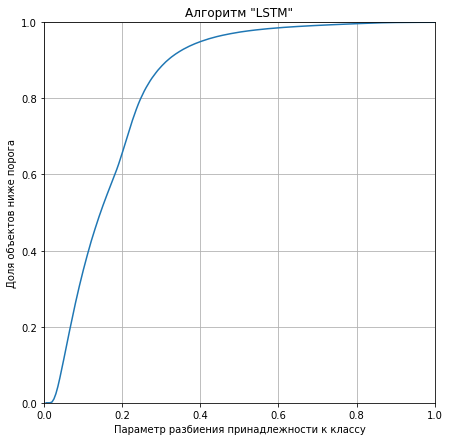

In [0]:
plts = measure_quality(y_test, proba, name='Алгоритм "LSTM"')